In [1]:
import cv2
import numpy as np
import torch
import math
import pathlib
from IPython.display import display as ipy_display, clear_output
import matplotlib.pyplot as plt

%matplotlib inline
import time
# Define real tennis ball radius in meters (3.25 cm radius)
TENNIS_BALL_RADIUS_M = 0.0325

class TennisBallDetector:
    def __init__(self, model_path, camera_matrix=None, distortion_coeffs=None, collection_zone=None, cache=True, camera=False, show_frames=False, windows=False):
        """
        Initialize the TennisBallDetector.
        :param model_path: Path to the trained YOLO model.
        :param camera_matrix: Camera matrix from calibration (optional for camera mode).
        :param distortion_coeffs: Distortion coefficients from calibration (optional for camera mode).
        :param collection_zone: A tuple defining the region for collection (x_min, y_min, x_max, y_max).
        :param camera: If True, capture frames from camera instead of reading from an image.
        """
        # Pathlib management based on OS
        if windows:
            # For Windows, use WindowsPath
            pathlib.PosixPath = pathlib.WindowsPath
        # Convert the model path to pathlib.Path and ensure it's a string
        self.model_path = pathlib.Path(model_path)
        self.model_path_str = str(self.model_path)

        # Load YOLO model based on caching preference
        if cache:
            self.model = torch.hub.load('ultralytics/yolov5', 'custom', path=self.model_path_str, trust_repo=True)
        else:
            self.model = torch.hub.load('ultralytics/yolov5', 'custom', path=self.model_path_str, force_reload=True)

        self.camera_matrix = camera_matrix
        self.distortion_coeffs = distortion_coeffs
        self.collection_zone = collection_zone
        self.camera_mode = camera
        self.show_frames = show_frames

        if self.camera_mode:
            # Initialize the camera
            self.camera = cv2.VideoCapture(0)  # Use 0 for default camera
            if not self.camera.isOpened():
                print("Error: Could not open USB camera.")
                exit()

    def undistort(self, frame):
        """
        Undistort the image using the camera matrix and distortion coefficients.
        :param frame: The distorted input frame.
        :return: The undistorted frame.
        """
        if self.camera_matrix is not None and self.distortion_coeffs is not None:
            return cv2.undistort(frame, self.camera_matrix, self.distortion_coeffs)
        return frame  # Return original frame if no calibration data is provided

    def calculate_distance(self, u, v, r_px):
        """
        Calculate the distance and angle to the tennis ball.
        :param u: The x-coordinate of the detected object (in pixels).
        :param v: The y-coordinate of the detected object (in pixels).
        :param r_px: The detected radius of the object in pixels.
        :return: (distance, angle) in meters and radians.
        """
        fx = self.camera_matrix[0, 0]  # Focal length in x direction
        cx = self.camera_matrix[0, 2]  # Principal point x-coordinate

        # Distance to the object in meters
        distance = fx * TENNIS_BALL_RADIUS_M / r_px

        # Calculate the offset in the x-direction
        y = (u - cx) * (TENNIS_BALL_RADIUS_M / r_px)

        # Calculate the angle
        angle = math.asin(y / distance)

        return distance, angle
    
    def detect(self, retry=True, max_num_retries=20, retry_interval=1):
        """
        Detect the tennis ball and return its coordinates and angle relative to the robot.
        Uses camera capture if camera_mode is enabled.
        :param retry: If True, retry if capture fails.
        :param max_num_retries: Maximum number of retries if capture fails.
        :param retry_interval: Time in seconds to wait between retries.
        :return: (u, v, distance, angle) if a tennis ball is detected, otherwise None.
        """
        counter = 0
        while True:
            # Capture frame from the camera or read from a file
            if self.camera_mode:
                ret, frame = self.camera.read()
                if not ret:
                    print("Error: Failed to capture image.")
                    if not retry or counter >= max_num_retries:
                        return None
                    counter += 1
                    time.sleep(retry_interval)
                    continue
            else:
                frame = cv2.imread('../tennis_ball/image_22.jpg')

            undistorted_frame = self.undistort(frame)
            results = self.model(undistorted_frame)

            # Extract bounding box and center of detected tennis ball
            detections = results.xyxy[0].cpu().numpy()  # Get detections in numpy format
            if len(detections) > 0:
                x1, y1, x2, y2, confidence, class_id = detections[0]

                # Calculate the center (u, v) and radius in pixels
                u = (x1 + x2) / 2  # x-coordinate of the center
                v = (y1 + y2) / 2  # y-coordinate of the center
                r_px = (x2 - x1) / 2  # Radius of the bounding box in pixels

                # Calculate distance and angle to the tennis ball
                distance, angle = self.calculate_distance(u, v, r_px)
                
                # Draw the bounding box and label
                if self.show_frames:
                    for index, obj in results.pandas().xyxy[0].iterrows():
                        x_min, y_min = int(obj['xmin']), int(obj['ymin'])
                        x_max, y_max = int(obj['xmax']), int(obj['ymax'])

                        # Draw bounding box and label
                        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                        label = f"{obj['name']} {obj['confidence']:.2f}"
                        cv2.putText(frame, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                    # Convert frame from BGR to RGB for display
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    
                    # Clear previous output and display the new frame
                    clear_output(wait=True)
                    plt.figure(figsize=(10, 6))
                    plt.imshow(frame_rgb)
                    plt.axis('off')  # Hide axes ticks
                    ipy_display(plt.gcf())  # Display the current figure
                    plt.close()  # Close the figure to prevent display duplication                    

                return u, v, distance, angle
            else:
                print("No ball detected.")
                if self.camera_mode:
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        break
                return None

    def is_in_collection_zone(self, u, v):
        """
        Check if the detected tennis ball is in the defined collection zone.
        :param u: The x-coordinate of the detected ball's center.
        :param v: The y-coordinate of the detected ball's center.
        :return: True if the ball is in the collection zone, False otherwise.
        """
        x_min, y_min, x_max, y_max = self.collection_zone
        return x_min <= u <= x_max and y_min <= v <= y_max

    def release(self):
        """
        Release the camera if camera mode is enabled.
        """
        if self.camera_mode:
            self.camera.release()
            cv2.destroyAllWindows()


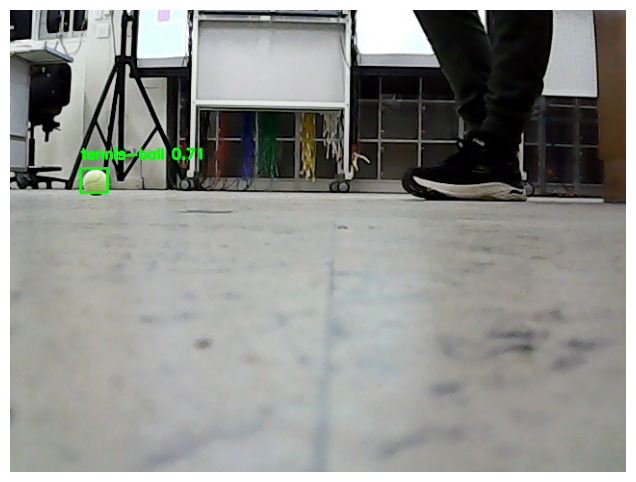

Distance: 1.51 meters, Angle: -14.63 degrees
Ball is not in the collection zone


In [2]:

# Load the YOLO model and calibration data
model_path = 'best.pt'
camera_matrix = np.load('camera_matrix.npy')
distortion_coeffs = np.load('distortion.npy')
collection_zone = (200, 150, 400, 350)  # Define a region for collection

detector = TennisBallDetector(model_path, camera_matrix, distortion_coeffs, collection_zone, camera=False, show_frames=True, windows=True)

# Detect tennis ball and get its coordinates
for _ in range(10):  # Run for a limited number of frames for testing
    detection = detector.detect()
    if detection:
        u, v, distance, angle = detection
        print(f"Distance: {distance:.2f} meters, Angle: {math.degrees(angle):.2f} degrees")

        # Check if the ball is in the collection zone
        if detector.is_in_collection_zone(u, v):
            print("Ball is in the collection zone")
        else:
            print("Ball is not in the collection zone")
    else:
        print("No ball detected.")